# CAB420, Practical 1 - Question 2 Solution
## Linear Regression

Using the dataset from Problem 1, split the data into training, validation and testing as follows:
* Training: All data from the years 2014-2016
* Validation: All data from 2017
* Training: All data from 2018

Develop a regression model to predict one of the cycleway data series in your dataset. In developing this model you should:
* Initially, use all weather data (temperature, rainfall and solar exposure) and all other data series for a particular counter type (i.e. if you’re predicting cyclists inbound for a counter, use all other cyclist inbound counters)
* Use p-values, qqplots, and performance on the validation set to remove terms and improve the model.

When you have finished refining the model, evaluate it on test set, and compare the Root Mean Squared Error (RMSE) for the training, validation and test sets.

In training the model, you will need to ensure that you have no samples (i.e. rows) with missing data. As such, you should remove samples with missing data from the dataset before training and evaluating the model. This may also mean that you have to remove some columns that contain large amounts of missing data.

In [1]:
# numpy handles pretty much anything that is a number/vector/matrix/array
import numpy as np
# pandas handles dataframes
import pandas as pd
# matplotlib emulates Matlabs plotting functionality
import matplotlib.pyplot as plt
# seaborn is another good plotting library. In particular, I like it for heatmaps (https://seaborn.pydata.org/generated/seaborn.heatmap.html)
import seaborn as sns;
# stats models is a package that is going to perform the regression analysis
from statsmodels import api as sm
from scipy import stats
from sklearn.metrics import mean_squared_error
# os allows us to manipulate variables on out local machine, such as paths and environment variables
import os
# self explainatory, dates and times
from datetime import datetime, date
# a helper package to help us iterate over objects
import itertools

Start by loading the data we merged in Q1.

In [2]:
combined = pd.read_csv('combinedData-Python.csv')
combined['Date']= pd.to_datetime(combined['Date'])
combined.head()

,Unnamed: 0,Rainfall amount (millimetres),Date,Maximum temperature (Degree C),Daily global solar exposure (MJ/m*m),Story Bridge West Pedestrian Inbound,Granville Street Bridge Cyclists Inbound,Kedron Brook Bikeway Lutwyche Pedestrians Inbound,Bicentennial Bikeway Cyclists Inbound,Jack Pesch Bridge Cyclists Outbound,...,Kedron Brook Bikeway Lutwyche Cyclists Outbound,Kedron Brook Bikeway Mitchelton Cyclist Inbound,Ekibin Park Cyclists Outbound,Jack Pesch Bridge Cyclists Inbound,Kedron Brook Bikeway Mitchelton Cyclist Outbound,Story Bridge East Cyclists Inbound,Bishop Street Cyclists Outbound,Story Bridge East Cyclists Outbound,Kedron Brook Bikeway Mitchelton Pedestrian Inbound,Bicentennial Bikeway Cyclists Outbound
0,0,0.0,2014-01-01,30.6,31.2,0.0,NaN,NaN,569.0,NaN,...,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN,572.0
1,1,0.0,2014-01-02,31.8,23.4,0.0,NaN,NaN,658.0,NaN,...,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN,700.0
2,2,1.0,2014-01-03,34.5,29.6,0.0,NaN,NaN,463.0,NaN,...,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN,412.0
3,3,0.0,2014-01-04,38.7,30.5,0.0,NaN,NaN,410.0,NaN,...,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN,364.0
4,4,0.0,2014-01-05,33.6,15.7,0.0,NaN,NaN,654.0,NaN,...,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN,641.0


Now find columns/features/covariates that have a suitable amount of data, lets say 300 is the minimum number of samples we need.

In [3]:
threshold = 300
columns_to_remove = []
for column in combined.columns.values:
  if np.sum(combined[column].isna()) > 300:
    # add this column to the list that should be removed
    columns_to_remove.append(column)

print(columns_to_remove)
print(len(columns_to_remove))    
# now lets remove them
combined = combined.drop(columns_to_remove, axis=1)
print(combined.shape)

['Granville Street Bridge Cyclists Inbound', 'Kedron Brook Bikeway Lutwyche Pedestrians Inbound', 'Jack Pesch Bridge Cyclists Outbound', 'Riverwalk Cyclists Outbound', 'Jack Pesch Bridge Pedestrians Inbound', 'Kedron Brook Bikeway Mitchelton Pedestrian Outbound', 'Riverwalk Cyclists Inbound', 'Jack Pesch Bridge Pedestrians Outbound', 'Riverwalk Pedestrians Outbound', 'Bishop Street Pedestrians Inbound', 'Riverwalk Pedestrians Inbound', 'Granville Street Bridge Pedestrians Outbound', 'Ekibin Park Pedestrians Inbound', 'Kedron Brook Bikeway Mitchelton', 'Bishop Street Pedestrians Outbound', 'Kedron Brook Bikeway Lutwyche', 'Kedron Brook Bikeway Lutwyche Pedestrians Outbound', 'North Brisbane Bikeway Mann Park Windsor Cyclists Outbound', 'Ekibin Park Cyclists Inbound', 'Story Bridge West Cyclists Outbound', 'Bishop Street Cyclists Inbound', 'Ekibin Park Pedestrians Outbound', 'Kedron Brook Bikeway Lutwyche Cyclists Inbound', 'Granville Street Bridge Cyclists Outbound', 'Granville Street B

Now drop any rows that contain a NaN.

In [4]:
print(np.sum(combined.isna(), axis=1))
print(np.sum(np.sum(combined.isna(), axis=1) > 0))
nans = combined.isna()
print(type(nans))
nans.to_csv('nans.csv')

combined_filtered = combined.dropna(axis=0)
# lets have a look at the final data set
print(combined_filtered.head())
print('Final dataset shape = {}'.format(combined_filtered.shape))
print(combined.iloc[11, :])

0       3
1       3
2       3
3       3
4       3
       ..
1821    0
1822    0
1823    0
1824    0
1825    0
Length: 1826, dtype: int64
404
<class 'pandas.core.frame.DataFrame'>
     Unnamed: 0  Rainfall amount (millimetres)       Date  \
169         169                            0.0 2014-06-19   
170         170                            5.8 2014-06-20   
171         171                            0.0 2014-06-21   
172         172                            5.2 2014-06-22   
173         173                            0.2 2014-06-23   

     Maximum temperature (Degree C)  Daily global solar exposure (MJ/m*m)  \
169                            20.3                                   8.0   
170                            22.5                                   9.1   
171                            25.6                                  12.9   
172                            24.2                                  13.0   
173                            24.1                                  

Split into train/test splits.

We'll split the data by time such that pre-2017 is training, 2018 is validation and 2019 is testing.

As a sanity check, we'll print the size of each set when we're finished.

In [5]:
train = combined_filtered[combined_filtered.Date < datetime(year=2017, month=1, day=1)]
val = combined_filtered[((combined_filtered.Date >= datetime(year=2017, month=1, day=1)) &
                        (combined_filtered.Date < datetime(year=2018, month=1, day=1)))]
test = combined_filtered[((combined_filtered.Date >= datetime(year=2018, month=1, day=1)) &
                          (combined_filtered.Date < datetime(year=2019, month=1, day=1)))]
print('num train = {}'.format(train.shape[0]))
print('val train = {}'.format(val.shape[0]))
print('test train = {}'.format(test.shape[0]))

num train = 888
val train = 276
test train = 258


Now we want to perform linear regression using Ordinary Least Squares. We want to use all weather data from the BOM to start with

In [6]:
X_bom = ['Rainfall amount (millimetres)',
         'Daily global solar exposure (MJ/m*m)',
         'Maximum temperature (Degree C)']

We can use any of the counters that we chose. We'll select 'Bicentennial Bikeway Cyclists Inbound' as our response, and use the rest of the inbound counters as our predictors along side thte BOM data.

In [7]:
# want to use all variables cyclist inbound variables
X_bcc = [x for x in train.columns.values if 'Cyclists Inbound' in x]
# remove the response variable from here
X_bcc.remove('Bicentennial Bikeway Cyclists Inbound')
# combine this list of variables together by just extending the
# BOM data with the BCC data
X_variables = X_bom + X_bcc
Y_variable = 'Bicentennial Bikeway Cyclists Inbound'
Y_train = np.array(train[Y_variable], dtype=np.float64)
X_train = np.array(train[X_variables], dtype=np.float64)
# want to add a constant to the model (the y-axis intercept)
X_train = sm.add_constant(X_train)

Also create validation and test data.

In [8]:
Y_val = np.array(val[Y_variable], dtype=np.float64)
X_val = np.array(val[X_variables], dtype=np.float64)
X_val = sm.add_constant(X_val)

Y_test = np.array(test[Y_variable], dtype=np.float64)
X_test = np.array(test[X_variables], dtype=np.float64)
X_test = sm.add_constant(X_test)

Before we go any further, we'll quickly pull out the correlations between variables.

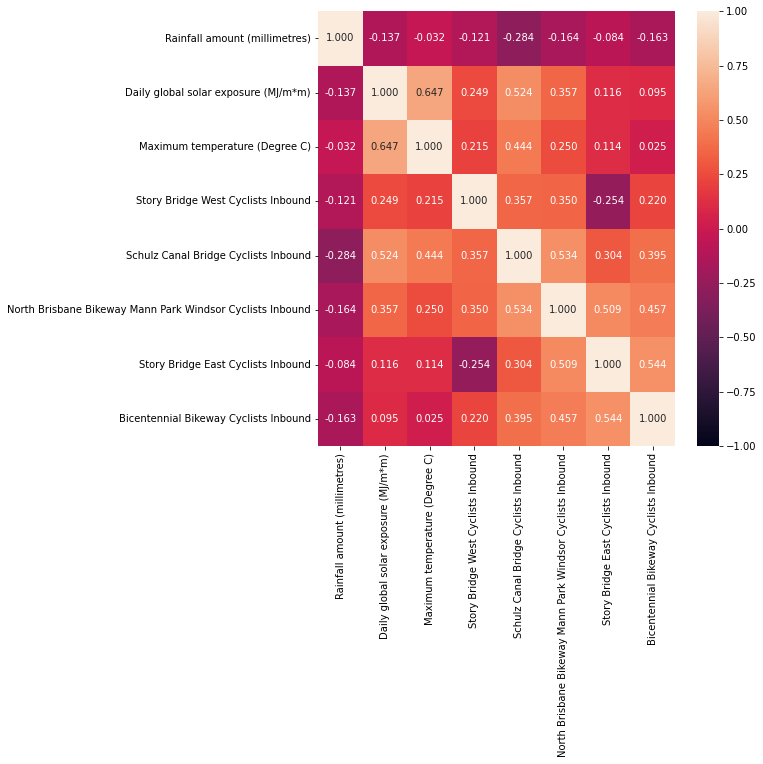

In [9]:
all_variables = X_variables + ['Bicentennial Bikeway Cyclists Inbound']
corr_coeffs = train[all_variables].corr()
fig, ax = plt.subplots(figsize=(8,8))
ax = sns.heatmap(corr_coeffs, annot=True, fmt="1.3f", vmin=-1.0, vmax=1.0)

From the above, we can see that:
* our temperature variables (x1, x2 and x3) are not very strongly correlated with our response. Temperature is very weakly correlated in particular.
* there is positive correltion between our response and the "counter" variabes (x4-x7). x4 (story bridge west) is the weakest.
* There is some correlation between some of our predictors. In particular:
  * Daily solar exposure and maximum temperature are correlated, this makes sense really
  * A number of our counters are correlated with each other, again, ths makes sense

Given this, it's likely we'll see some terms that are not too crash hot in our model. That's ok - we'll train the model then clean it up.

Now create the model and evaluate it

Model 1 RMSE = 623.3791739360695
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.474
Model:                            OLS   Adj. R-squared:                  0.469
Method:                 Least Squares   F-statistic:                     113.1
Date:                Sun, 13 Mar 2022   Prob (F-statistic):          4.59e-118
Time:                        20:13:42   Log-Likelihood:                -6899.6
No. Observations:                 888   AIC:                         1.382e+04
Df Residuals:                     880   BIC:                         1.385e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        739.22

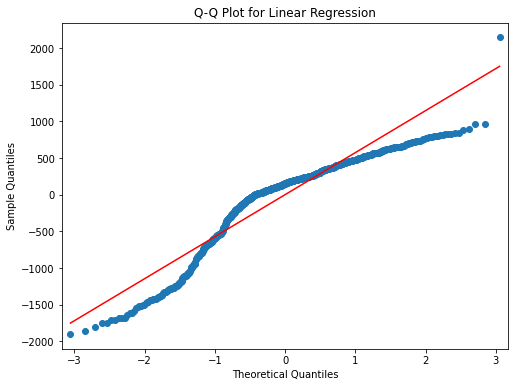

In [10]:
# create the linear model
model = sm.OLS(Y_train, X_train)
# fit the model
model_1_fit = model.fit()
pred = model_1_fit.predict(X_val)
print('Model 1 RMSE = {}'.format(
  np.sqrt(mean_squared_error(Y_val, model_1_fit.predict(X_val)))))
print(model_1_fit.summary())
print(model_1_fit.params)
fig, ax = plt.subplots(figsize=(8,6))
sm.qqplot(model_1_fit.resid, ax=ax, line='s')
plt.title('Q-Q Plot for Linear Regression')
plt.show()

Our initial residual plot looks pretty bad. The wonky trend in our residuals suggests that the i.i.d. assumption made when performing ordinary least squares is bad. This implies that the variance is not common within our data samples, meaning that our dataset is heteroskedastic (don't need to worry too much about the implications of this for this class, but the concepts of homoskedasticity and heteroskedasticity are important for successful application of stats/ML models).

Despite this poor model, we will continue on looking to see if we can tidy things up within a OLS model.

From above (and repeated here for convenience) we have some terms that have a weak relationship with our model.

[[ 1.         -0.1373654  -0.03216845 -0.12134364 -0.28375855 -0.16416081
  -0.08392224 -0.16317026]
 [-0.1373654   1.          0.64749344  0.24915125  0.52359272  0.35713766
   0.1162428   0.09517715]
 [-0.03216845  0.64749344  1.          0.21496214  0.44445062  0.25038631
   0.11422163  0.02452469]
 [-0.12134364  0.24915125  0.21496214  1.          0.35673773  0.34952993
  -0.25427468  0.22037637]
 [-0.28375855  0.52359272  0.44445062  0.35673773  1.          0.53424962
   0.30354061  0.39493691]
 [-0.16416081  0.35713766  0.25038631  0.34952993  0.53424962  1.
   0.5092007   0.45741757]
 [-0.08392224  0.1162428   0.11422163 -0.25427468  0.30354061  0.5092007
   1.          0.54449222]
 [-0.16317026  0.09517715  0.02452469  0.22037637  0.39493691  0.45741757
   0.54449222  1.        ]]


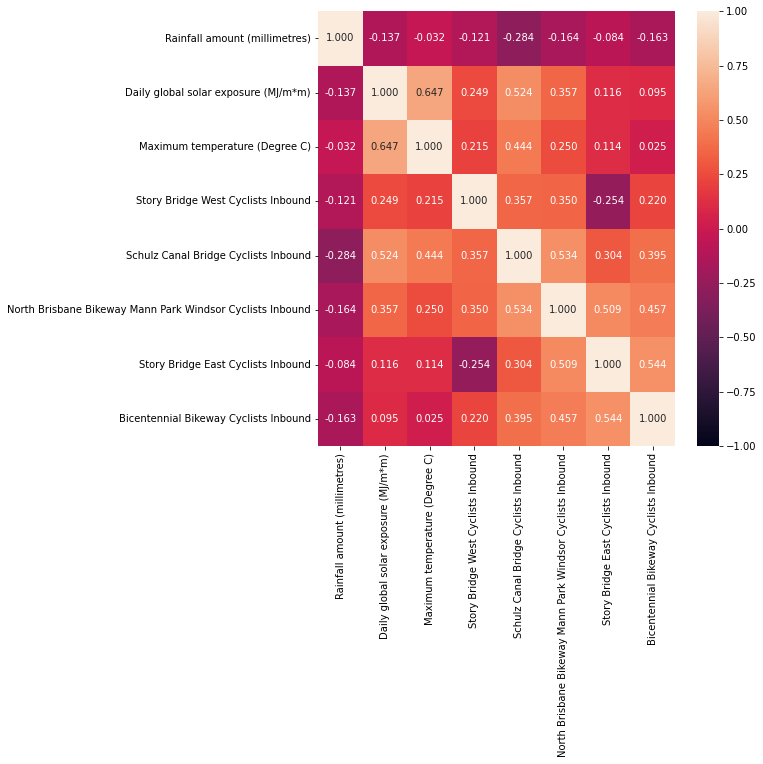

In [11]:
fig, ax = plt.subplots(figsize=(8,8))
ax = sns.heatmap(corr_coeffs, annot=True, fmt="1.3f", vmin=-1.0, vmax=1.0)
print(np.array(corr_coeffs))

There is little evidence in our dataset to identify a linear relationship (correlation) between variables (1 and 2) with our response. So, lets remove them and see what happens.

We'll start by removing the first variable.

In [12]:
to_remove = [X_variables[0]]
print('Variables to remove -> {}'.format(to_remove[0]))
train = train.drop(X_variables[0], axis=1)
# also want to remove these variable names from the X_variable list
X_variables.remove(to_remove[0])
print(X_variables)
# now lets create a new model and perform regression on that
X_train = np.array(train[X_variables], dtype=np.float64)

# want to add a constant to the model (the y-axis intercept)
X_train = sm.add_constant(X_train)
# also creating validation and testing data
Y_val = np.array(val[Y_variable], dtype=np.float64)
X_val = np.array(val[X_variables], dtype=np.float64)
X_val = sm.add_constant(X_val)
Y_test = np.array(test[Y_variable], dtype=np.float64)
X_test = np.array(test[X_variables], dtype=np.float64)
X_test = sm.add_constant(X_test)

Variables to remove -> Rainfall amount (millimetres)
['Daily global solar exposure (MJ/m*m)', 'Maximum temperature (Degree C)', 'Story Bridge West Cyclists Inbound', 'Schulz Canal Bridge Cyclists Inbound', 'North Brisbane Bikeway Mann Park Windsor Cyclists Inbound', 'Story Bridge East Cyclists Inbound']


In [13]:
# now make the model and fit it
model_2 = sm.OLS(Y_train, X_train)
# fit the model without any regularisation
model_2_fit = model_2.fit()
pred = model_2_fit.predict(X_val)
print('Model 1 RMSE = {}'.format(
  np.sqrt(mean_squared_error(Y_val, model_2_fit.predict(X_val)))))
print(model_2_fit.summary())
print(model_2_fit.params)

Model 1 RMSE = 622.6997548236515
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.473
Model:                            OLS   Adj. R-squared:                  0.469
Method:                 Least Squares   F-statistic:                     131.6
Date:                Sun, 13 Mar 2022   Prob (F-statistic):          8.12e-119
Time:                        20:13:43   Log-Likelihood:                -6900.4
No. Observations:                 888   AIC:                         1.381e+04
Df Residuals:                     881   BIC:                         1.385e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        726.33

x1 (formerly x2) still looks ordinary, so we'll remove that as well

In [14]:
to_remove = [X_variables[0]]
print('Variable to remove -> {}'.format(to_remove[0]))
train = train.drop([X_variables[0]], axis=1)
# also want to remove these variable names from the X_variable list
X_variables.remove(to_remove[0])
print(X_variables)
# now lets create a new model and perform regression on that
X_train = np.array(train[X_variables], dtype=np.float64)
# want to add a constant to the model (the y-axis intercept)
X_train = sm.add_constant(X_train)
# also creating validation and testing data
Y_val = np.array(val[Y_variable], dtype=np.float64)
X_val = np.array(val[X_variables], dtype=np.float64)
X_val = sm.add_constant(X_val)
Y_test = np.array(test[Y_variable], dtype=np.float64)
X_test = np.array(test[X_variables], dtype=np.float64)
X_test = sm.add_constant(X_test)

Variable to remove -> Daily global solar exposure (MJ/m*m)
['Maximum temperature (Degree C)', 'Story Bridge West Cyclists Inbound', 'Schulz Canal Bridge Cyclists Inbound', 'North Brisbane Bikeway Mann Park Windsor Cyclists Inbound', 'Story Bridge East Cyclists Inbound']


In [15]:
# now make the model and fit it
model_3 = sm.OLS(Y_train, X_train)
# fit the model without any regularisation
model_3_fit = model_3.fit()
pred = model_3_fit.predict(X_val)
print('Model 1 RMSE = {}'.format(
  np.sqrt(mean_squared_error(Y_val, model_3_fit.predict(X_val)))))
print(model_3_fit.summary())
print(model_3_fit.params)

Model 1 RMSE = 617.2291087210774
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.472
Model:                            OLS   Adj. R-squared:                  0.469
Method:                 Least Squares   F-statistic:                     157.4
Date:                Sun, 13 Mar 2022   Prob (F-statistic):          1.50e-119
Time:                        20:13:43   Log-Likelihood:                -6901.3
No. Observations:                 888   AIC:                         1.381e+04
Df Residuals:                     882   BIC:                         1.384e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        792.43

### Removing other variables

x4 (mann park) is still looking poor - but we have a high degree of correlation between this variable and our other predictors. This makes the p-values potentially misleading, and we need to consider this a bit more carefully. Let's look at a few options.

#### Remove Mann Park

In [16]:
train_backup = train.copy()
X_variables_backup = X_variables.copy()

to_remove = [X_variables[3]]
print('Variable to remove -> {}'.format(to_remove[0]))
train = train.drop([X_variables[3]], axis=1)
# also want to remove these variable names from the X_variable list
X_variables.remove(to_remove[0])
print(X_variables)
# now lets create a new model and perform regression on that
X_train = np.array(train[X_variables], dtype=np.float64)
# want to add a constant to the model (the y-axis intercept)
X_train = sm.add_constant(X_train)
# also creating validation and testing data
Y_val = np.array(val[Y_variable], dtype=np.float64)
X_val = np.array(val[X_variables], dtype=np.float64)
X_val = sm.add_constant(X_val)
Y_test = np.array(test[Y_variable], dtype=np.float64)
X_test = np.array(test[X_variables], dtype=np.float64)
X_test = sm.add_constant(X_test)

# now make the model and fit it
model_4a = sm.OLS(Y_train, X_train)
# fit the model without any regularisation
model_4a_fit = model_4a.fit()
pred = model_4a_fit.predict(X_val)
print('Model 4 RMSE = {}'.format(
  np.sqrt(mean_squared_error(Y_val, model_4a_fit.predict(X_val)))))
print(model_4a_fit.summary())
print(model_4a_fit.params)

Variable to remove -> North Brisbane Bikeway Mann Park Windsor Cyclists Inbound
['Maximum temperature (Degree C)', 'Story Bridge West Cyclists Inbound', 'Schulz Canal Bridge Cyclists Inbound', 'Story Bridge East Cyclists Inbound']
Model 4 RMSE = 614.9652599304142
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.471
Model:                            OLS   Adj. R-squared:                  0.469
Method:                 Least Squares   F-statistic:                     196.5
Date:                Sun, 13 Mar 2022   Prob (F-statistic):          1.75e-120
Time:                        20:13:43   Log-Likelihood:                -6901.8
No. Observations:                 888   AIC:                         1.381e+04
Df Residuals:                     883   BIC:                         1.384e+04
Df Model:                           4                                         
Covariance Type:         

#### Remove Schultz Canal

In [17]:
train = train_backup.copy()
X_variables = X_variables_backup.copy()

to_remove = [X_variables[2]]
print('Variable to remove -> {}'.format(to_remove[0]))
train = train.drop([X_variables[2]], axis=1)
# also want to remove these variable names from the X_variable list
X_variables.remove(to_remove[0])
print(X_variables)
# now lets create a new model and perform regression on that
X_train = np.array(train[X_variables], dtype=np.float64)
# want to add a constant to the model (the y-axis intercept)
X_train = sm.add_constant(X_train)
# also creating validation and testing data
Y_val = np.array(val[Y_variable], dtype=np.float64)
X_val = np.array(val[X_variables], dtype=np.float64)
X_val = sm.add_constant(X_val)
Y_test = np.array(test[Y_variable], dtype=np.float64)
X_test = np.array(test[X_variables], dtype=np.float64)
X_test = sm.add_constant(X_test)

# now make the model and fit it
model_4b = sm.OLS(Y_train, X_train)
# fit the model without any regularisation
model_4b_fit = model_4b.fit()
pred = model_4b_fit.predict(X_val)
print('Model 4 RMSE = {}'.format(
  np.sqrt(mean_squared_error(Y_val, model_4b_fit.predict(X_val)))))
print(model_4b_fit.summary())
print(model_4b_fit.params)

Variable to remove -> Schulz Canal Bridge Cyclists Inbound
['Maximum temperature (Degree C)', 'Story Bridge West Cyclists Inbound', 'North Brisbane Bikeway Mann Park Windsor Cyclists Inbound', 'Story Bridge East Cyclists Inbound']
Model 4 RMSE = 610.0287420836287
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.453
Model:                            OLS   Adj. R-squared:                  0.450
Method:                 Least Squares   F-statistic:                     182.7
Date:                Sun, 13 Mar 2022   Prob (F-statistic):          4.69e-114
Time:                        20:13:43   Log-Likelihood:                -6916.8
No. Observations:                 888   AIC:                         1.384e+04
Df Residuals:                     883   BIC:                         1.387e+04
Df Model:                           4                                         
Covariance Type:         

#### Remove Storey Bridge West

In [18]:
train = train_backup.copy()
X_variables = X_variables_backup.copy()

to_remove = [X_variables[1]]
print('Variable to remove -> {}'.format(to_remove[0]))
train = train.drop([X_variables[1]], axis=1)
# also want to remove these variable names from the X_variable list
X_variables.remove(to_remove[0])
print(X_variables)
# now lets create a new model and perform regression on that
X_train = np.array(train[X_variables], dtype=np.float64)
# want to add a constant to the model (the y-axis intercept)
X_train = sm.add_constant(X_train)
# also creating validation and testing data
Y_val = np.array(val[Y_variable], dtype=np.float64)
X_val = np.array(val[X_variables], dtype=np.float64)
X_val = sm.add_constant(X_val)
Y_test = np.array(test[Y_variable], dtype=np.float64)
X_test = np.array(test[X_variables], dtype=np.float64)
X_test = sm.add_constant(X_test)

# now make the model and fit it
model_4c = sm.OLS(Y_train, X_train)
# fit the model without any regularisation
model_4c_fit = model_4c.fit()
pred = model_4c_fit.predict(X_val)
print('Model 4 RMSE = {}'.format(
  np.sqrt(mean_squared_error(Y_val, model_4c_fit.predict(X_val)))))
print(model_4c_fit.summary())
print(model_4c_fit.params)

Variable to remove -> Story Bridge West Cyclists Inbound
['Maximum temperature (Degree C)', 'Schulz Canal Bridge Cyclists Inbound', 'North Brisbane Bikeway Mann Park Windsor Cyclists Inbound', 'Story Bridge East Cyclists Inbound']
Model 4 RMSE = 655.4173737523233
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.393
Model:                            OLS   Adj. R-squared:                  0.390
Method:                 Least Squares   F-statistic:                     142.8
Date:                Sun, 13 Mar 2022   Prob (F-statistic):           4.02e-94
Time:                        20:13:43   Log-Likelihood:                -6963.1
No. Observations:                 888   AIC:                         1.394e+04
Df Residuals:                     883   BIC:                         1.396e+04
Df Model:                           4                                         
Covariance Type:         

#### Remove Storey Bridge West

In [19]:
train = train_backup.copy()
X_variables = X_variables_backup.copy()

to_remove = [X_variables[4]]
print('Variable to remove -> {}'.format(to_remove[0]))
train = train.drop([X_variables[4]], axis=1)
# also want to remove these variable names from the X_variable list
X_variables.remove(to_remove[0])
print(X_variables)
# now lets create a new model and perform regression on that
X_train = np.array(train[X_variables], dtype=np.float64)
# want to add a constant to the model (the y-axis intercept)
X_train = sm.add_constant(X_train)
# also creating validation and testing data
Y_val = np.array(val[Y_variable], dtype=np.float64)
X_val = np.array(val[X_variables], dtype=np.float64)
X_val = sm.add_constant(X_val)
Y_test = np.array(test[Y_variable], dtype=np.float64)
X_test = np.array(test[X_variables], dtype=np.float64)
X_test = sm.add_constant(X_test)

# now make the model and fit it
model_4d = sm.OLS(Y_train, X_train)
# fit the model without any regularisation
model_4d_fit = model_4d.fit()
pred = model_4d_fit.predict(X_val)
print('Model 4 RMSE = {}'.format(
  np.sqrt(mean_squared_error(Y_val, model_4d_fit.predict(X_val)))))
print(model_4d_fit.summary())
print(model_4d_fit.params)

Variable to remove -> Story Bridge East Cyclists Inbound
['Maximum temperature (Degree C)', 'Story Bridge West Cyclists Inbound', 'Schulz Canal Bridge Cyclists Inbound', 'North Brisbane Bikeway Mann Park Windsor Cyclists Inbound']
Model 4 RMSE = 767.3653270659025
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.273
Model:                            OLS   Adj. R-squared:                  0.269
Method:                 Least Squares   F-statistic:                     82.71
Date:                Sun, 13 Mar 2022   Prob (F-statistic):           1.17e-59
Time:                        20:13:43   Log-Likelihood:                -7043.2
No. Observations:                 888   AIC:                         1.410e+04
Df Residuals:                     883   BIC:                         1.412e+04
Df Model:                           4                                         
Covariance Type:         

#### Final Model

From the above, we got the best results when we did in fact remove Mann Park, though not by much. After removing this variable, everything was significant, so we'll consider this the final model.

Finally, we'll run the model on the test data.

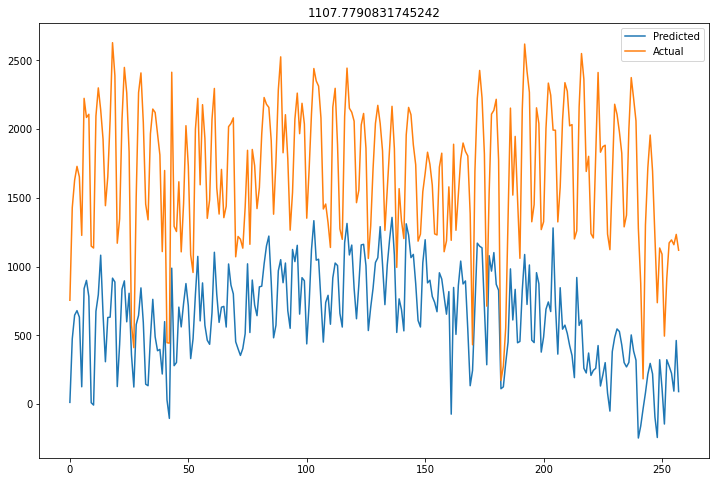

In [20]:
pred = model_4a_fit.predict(X_test)
rmse_test = np.sqrt(mean_squared_error(Y_test, pred))
fig = plt.figure(figsize=[12, 8])
ax = fig.add_subplot(1, 1, 1)
ax.plot(np.arange(len(pred)), pred, label='Predicted')
ax.plot(np.arange(len(Y_test)), Y_test, label='Actual')
ax.set_title(rmse_test)
ax.legend()

### Final Interesting Thoughts

Depending on what of model 4a, 4b, 4c and 4d you select, you will get very different results on the test set. 4a is best on the validation set, which is why it was chosen, but other models are better on the test set. This does not mean that our process is wrong, but rather suggests that there are some factors that have changed in our test set.